# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

###  

#### Importing all libraries used in the project

In [1]:
!pip install geocoder
!pip install folium
!pip install -U yellowbrick

Requirement already up-to-date: yellowbrick in c:\users\bruno\anaconda3\lib\site-packages (1.2.1)


In [2]:
import geocoder
import pandas as pd
import numpy as np
import folium
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

print("Libraries imported!")

Libraries imported!


## SECTION 1: INTRODUCTION AND BUSINESS PROBLEM

.

Porto Alegre is the largest city in the south of Brazil. Porto Alegre is home of more than 1.5 million people. In addition to its population, there are more 3 million people who live in its metropolitan area. Economically, Porto Alegre is also a very important city of Brazil as its GDP is the eight highest among all cities of Brazil.

Determining the location of a business is a crucial decision that business owners must make. In the case of restaurants, this decision is very critical. A bad location might be the reason for a good restaurant to close permanently. In this context, the objective of this project is to study what are the most promising areas to start a new Italian restaurant in the city of Porto Alegre so that the business has better chances of being successful. The present project will attempt to answer this question supported by data.

## SECTION 2: DATA ACQUISITION AND PREPROCESSING

.

The data sources are listed below:

1.	Wikipedia list of Porto Alegre neighbourhoods , their population and average income.
2.	Foursquare data on restaurants locations.
3.	Coordinates for each neighbourhoods  of Porto Alegre retrieved geocoder.


After gathering all data, data will be treated and cleaned. As the list of neighbourhoods  and their coordinates are in two separate datasets, both datasets will be merged. Additionally, the average income in the Wikipedia dataset is provided in terms of “Minimum monthly salary per household”. Therefore, it will be converted to Brazilian Reais (BRL), utilizing the value of the current minimum monthly salary.

The following criteria will be used to analyze the neighbourhoods in Porto Alegre:

1.	Average income
2.	Total population
3.	Number of restaurants


First step in the project was to acquire the data from different sources and prepare it, so it can be used in the project.


The list of neighbourhoods of Porto Alegre was collected from wikipedia utilizing the following code:

In [156]:
#read table from wikipedia and create pandas dataframe
table = pd.read_html("https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Porto_Alegre")
df = pd.DataFrame(table[1])
df = pd.DataFrame(df)

#data cleaning
df = df.drop(['Data de Criação','Área','Tx Cresc Pop 91-00','Densidade','Nota'], axis = 1)
df = df.drop([96])
df = df.drop([95])
df = df.dropna()

#translating column names to English
df = df.rename(columns={"Bairro":"Neighbourhood","População2010" : "Population", "Renda média por domicílio":"Average income (BRL)"})
df["Average income (BRL)"] = df["Average income (BRL)"].astype(str)

#Adjusting average income: replacing "," for "." and multiplying by Minimum Salary
df["Average income (BRL)"] = df["Average income (BRL)"].map(lambda x: x.rstrip(' SM/mês'))
df["Average income (BRL)"] = df["Average income (BRL)"].str.replace(',', '.')
df["Average income (BRL)"] = df["Average income (BRL)"].astype(float)
df["Average income (BRL)"] = 1100*df["Average income (BRL)"]
df["Population"] = df["Population"].astype(int)
pd.options.display.float_format = "{:,.2f}".format
df = df.reset_index(drop=True)

#data after cleaning
print('Number of columns =', df.shape[1])
print('Number of rows =', df.shape[0])


pd.set_option("display.max_rows", None, "display.max_columns", None)
df.head(3)

Number of columns = 3
Number of rows = 79


,Neighbourhood,Population,Average income (BRL)
0,Agronomia,12222,"4,378.00"
1,Anchieta,203,"9,251.00"
2,Arquipélago,5061,"3,256.00"


In [157]:
df.at[15, "Neighbourhood"] = "Centro Histórico"

In [159]:
#creating df with Neighbourhoods only
df_neighbourhood = pd.DataFrame(df['Neighbourhood'])
df_neighbourhood = df_neighbourhood.apply(lambda s: s+ ", Porto Alegre, Brasil")

#reseting variables and creating empty dataframe
latitude=[]
longitude=[]
coordinates = pd.DataFrame(columns=['Neighbourhood2','Latitude','Longitude'])

In [160]:
df_neighbourhood

,Neighbourhood
0,"Agronomia, Porto Alegre, Brasil"
1,"Anchieta, Porto Alegre, Brasil"
2,"Arquipélago, Porto Alegre, Brasil"
3,"Auxiliadora, Porto Alegre, Brasil"
4,"Azenha, Porto Alegre, Brasil"
5,"Bela Vista, Porto Alegre, Brasil"
6,"Belém Novo, Porto Alegre, Brasil"
7,"Belém Velho, Porto Alegre, Brasil"
8,"Boa Vista, Porto Alegre, Brasil"
9,"Bom Jesus, Porto Alegre, Brasil"


.

As Wikipedia did not provide the geographical coordinates for each neighbourhood in Porto Alegre, this was done utiling geocoder. The code below acquire the data using geocoder and creates a table called "coordinates".

In [161]:
i = 0
rows = df.shape[0]-1

while i<=rows:
    x = df_neighbourhood['Neighbourhood'][i]
    g = geocoder.arcgis(x)
    latitude=g.latlng[0]
    longitude=g.latlng[1]
    coordinates = coordinates.append({'Neighbourhood2' : x , 'Latitude' : latitude, 'Longitude': longitude},ignore_index=True)
    i=i+1

In [203]:
#checking if coordinates were collected appropriately
coordinates.head()

,Neighbourhood2,Latitude,Longitude
0,"Agronomia, Porto Alegre, Brasil",-30.09,-51.12
1,"Anchieta, Porto Alegre, Brasil",-29.98,-51.17
2,"Arquipélago, Porto Alegre, Brasil",-29.99,-51.23
3,"Auxiliadora, Porto Alegre, Brasil",-30.02,-51.19
4,"Azenha, Porto Alegre, Brasil",-30.05,-51.22


In [163]:
#merging the coordinates and the orignal dataframe
df = pd.concat([df, coordinates], axis = 1)
df = df.reset_index(drop=True)
df = df.drop("Neighbourhood2", axis=1)

.

Geographical coordinates for each neighbourhood were included in the original dataframe that contained only the data from Wikipedia.
The list of Neighbourhoods with their respective population, average income and coordinates is presented below:

In [205]:
df.head()

,Neighbourhood,Population,Average income (BRL),Latitude,Longitude
0,Agronomia,12222,"4,378.00",-30.09,-51.12
1,Anchieta,203,"9,251.00",-29.98,-51.17
2,Arquipélago,5061,"3,256.00",-29.99,-51.23
3,Auxiliadora,9985,"21,527.00",-30.02,-51.19
4,Azenha,13449,"11,803.00",-30.05,-51.22


.

Next, utilizing Foursquare and the dataframe containing the population, average income and coordinates for each neighbourhood, the list of venues of Porto Alegre was acquired.

In [1]:
#Collecting data from foursquare
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare Secret
VERSION = '20200126' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
CLIENT_SECRET:XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX


In [166]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [167]:
poavenues = getNearbyVenues(names=df['Neighbourhood'], latitudes=df['Latitude'], longitudes=df['Longitude'])

Agronomia
Anchieta
Arquipélago
Auxiliadora
Azenha
Bela Vista
Belém Novo
Belém Velho
Boa Vista
Bom Jesus
Bom Fim
Camaquã
Campo Novo
Cascata
Cavalhada
Centro Histórico
Chácara das Pedras
Cidade Baixa
Coronel Aparício Borges
Cristal
Cristo Redentor
Espírito Santo
Farrapos
Farroupilha
Floresta
Glória
Guarujá
Higienópolis
Hípica
Humaitá
Independência
Ipanema
Jardim Botânico
Jardim Carvalho
Jardim Floresta
Jardim Itu-Sabará
Jardim Lindóia
Jardim do Salso
Jardim São Pedro
Lageado
Lami
Lomba do Pinheiro
Marcílio Dias
Mário Quintana
Medianeira
Menino Deus
Moinhos de Vento
Mont'Serrat
Navegantes
Nonoai
Partenon
Passo D'Areia
Pedra Redonda
Petrópolis
Ponta Grossa
Praia de Belas
Restinga
Rio Branco
Rubem Berta
Santa Cecília
Santa Maria Goretti
Santa Tereza
Santana
Santo Antônio
São Geraldo
São João
Vila São José
São Sebastião
Sarandi
Serraria
Teresópolis
Três Figueiras
Tristeza
Vila Assunção
Vila Conceição
Vila Ipiranga
Vila Jardim
Vila João Pessoa
Vila Nova


.

Porto Alegre venues are listed below:

In [168]:
poavenues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Anchieta,-29.98,-51.17,Locare - Locadora de Materiais para Eventos,-29.99,-51.16,Department Store
1,Arquipélago,-29.99,-51.23,Restaurante da Ilha,-29.99,-51.23,Restaurant
2,Arquipélago,-29.99,-51.23,Motel da Ilha,-29.99,-51.23,Motel
3,Auxiliadora,-30.02,-51.19,Natasul,-30.02,-51.19,Gym Pool
4,Auxiliadora,-30.02,-51.19,Estética Visualite,-30.02,-51.19,Salon / Barbershop


.


As the project is interested in determing good locations to start a new Italian Restaurant, only food-related venues will be kept in the list. In other words, other venue categories such as "Department Store" will be removed from the list.

In [169]:
#keeping only columns related to restaurants
venues_list = pd.DataFrame(poavenues['Venue Category'].unique())

In [170]:
poa_restaurants = poavenues[poavenues['Venue Category'].isin(['Restaurant','German Restaurant','Southern Brazilian Restaurant','Mediterranean Restaurant','Japanese Restaurant','Italian Restaurant','Sushi Restaurant','Chinese Restaurant','Latin American Restaurant','Brazilian Restaurant','Comfort Food Restaurant','Australian Restaurant','Indian Restaurant','Vegetarian / Vegan Restaurant','Middle Eastern Restaurant','Mexican Restaurant','Fast Food Restaurant','Seafood Restaurant','French Restaurant','Swiss Restaurant','South American Restaurant','Falafel Restaurant','Korean Restaurant','Tapas Restaurant','Taiwanese Restaurant','Halal Restaurant','Thai Restaurant','American Restaurant','Argentinian Restaurant','Empanada Restaurant','Polish Restaurant','Baiano Restaurant','Churrascaria','Food Truck','Food Court','Food Stand','Bar','Beer Bar','Cocktail Bar','Dive Bar','Wine Bar','Bistro','BBQ Joint','Buffet','Burger Joint','Burrito Place','Creperie','Diner','Empada House','Fried Chicken Joint','Hot Dog Joint','Irish Pub','Pastelaria','Pizza Place','Poke Place','Pub','Sandwich Place','Steakhouse'])]
poa_restaurants.reset_index(drop=True, inplace=True)
poa_restaurants.head(2)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Arquipélago,-29.99,-51.23,Restaurante da Ilha,-29.99,-51.23,Restaurant
1,Auxiliadora,-30.02,-51.19,Prinz,-30.02,-51.19,German Restaurant


.

The number of restaurants in Porto Alegre per neighbourhood according to Foursquare is shown below:

In [171]:
poa_restaurants.groupby("Neighbourhood").count().head()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Arquipélago,1,1,1,1,1,1
Auxiliadora,20,20,20,20,20,20
Azenha,7,7,7,7,7,7
Bela Vista,5,5,5,5,5,5
Belém Novo,2,2,2,2,2,2


In [172]:
print('There are {} uniques categories.'.format(len(poavenues['Venue Category'].unique())))

There are 243 uniques categories.


.

One hot encoding was used to convert data so it can be used in the next steps:

In [173]:
# one hot encoding
poa_onehot = pd.get_dummies(poa_restaurants[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
poa_onehot['Neighbourhood'] = poa_restaurants['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [poa_onehot.columns[-1]] + list(poa_onehot.columns[:-1])
poa_onehot = poa_onehot[fixed_columns]

poa_grouped = poa_onehot.groupby('Neighbourhood').mean().reset_index()
poa_grouped.head()

,Neighbourhood,American Restaurant,Argentinian Restaurant,Australian Restaurant,BBQ Joint,Baiano Restaurant,Bar,Beer Bar,Bistro,Brazilian Restaurant,Buffet,Burger Joint,Burrito Place,Chinese Restaurant,Churrascaria,Cocktail Bar,Comfort Food Restaurant,Creperie,Diner,Dive Bar,Empada House,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,German Restaurant,Halal Restaurant,Hot Dog Joint,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Pastelaria,Pizza Place,Poke Place,Polish Restaurant,Pub,Restaurant,Sandwich Place,Seafood Restaurant,South American Restaurant,Southern Brazilian Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Wine Bar
0,Arquipélago,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,Auxiliadora,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.10,0.00,0.00,0.05,0.00,0.10,0.00,0.00,0.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.10,0.00,0.00,0.00,0.00,0.10,0.05,0.00,0.00,0.05,0.00,0.00,0.05,0.05,0.00,0.00,0.05,0.10,0.00,0.00,0.00,0.10,0.00,0.05,0.00,0.00,0.00,0.00,0.00,0.00
2,Azenha,0.00,0.00,0.00,0.00,0.00,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,Bela Vista,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.20,0.20,0.00,0.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,Belém Novo,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## SECTION 3: METHODOLOGY

.

In this section the methodology applied to this project will be explained.

.

The analysis will be performed in all Porto Alegre based on its neighbourhoods and their coordinates. To determine possible neighbourhoods for a new Italian restaurant in Porto Alegre all restaurants listed in Foursquare will be considered.

.

The analysis will first understand what neighbourhoods have higher population and higher average income. These regions will be the focus to determine the location of the new restaurant.

.

After, neighbourhoods will be classified based how similar they are in terms of restaurants. The objective of this step is to determine what are neighbourhoods known for its gastronomy as it is not the intention of the company to establish a new restaurant in a region that is not popular for its restaurants.

.

The first two analysis will exclude some neighbourhoods and rank some possible neighbourhoods. Based on the previous steps, the candidates will be compared only in terms of the number of Italian restaurants in the region.

## SECTION 4: DATA EXPLORATION AND ANALYSIS

.

In this section it will described how the data was explored and processed for analysis.

.

The first step was to generate a follium map of Porto Alegre containing only its neighbourhoods. The objective of this is step is to have a first contact with Porto Alegre and learn how neighbourhoods are distributed in the city. The code and the map is shown below:

In [174]:
#create map of Porto Alegre
lat_poa = -30.1
long_poa = -51.2287
map_poa = folium.Map(location=[lat_poa, long_poa], zoom_start=11)

#add markers
for lat, lng, neighbourhood in zip(df['Latitude'], df['Longitude'], df["Neighbourhood"]):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=[neighbourhood] ,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_poa)  

In [175]:
#show map
map_poa

.

Next step, was to understand how different type of restaurants are distributed in each neighbourhood.

In [176]:
num_top_venues = 5

for hood in poa_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = poa_grouped[poa_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arquipélago----
                 venue  freq
0           Restaurant  1.00
1  American Restaurant  0.00
2    Polish Restaurant  0.00
3    Indian Restaurant  0.00
4            Irish Pub  0.00


----Auxiliadora----
                venue  freq
0  Italian Restaurant  0.10
1   German Restaurant  0.10
2          Restaurant  0.10
3              Bistro  0.10
4  Chinese Restaurant  0.10


----Azenha----
                       venue  freq
0                 Restaurant  0.43
1                        Bar  0.14
2  Latin American Restaurant  0.14
3               Churrascaria  0.14
4             Sandwich Place  0.14


----Bela Vista----
                  venue  freq
0          Burger Joint  0.40
1                Bistro  0.20
2  Brazilian Restaurant  0.20
3           Pizza Place  0.20
4   American Restaurant  0.00


----Belém Novo----
                venue  freq
0          Restaurant  0.50
1              Bistro  0.50
2                 Pub  0.00
3           Irish Pub  0.00
4  Italian Restaurant  0.00

.

Then, based on the previous step, restaurants venues were ranked to create a list of most frequent venues for each neighbourhood.

In [177]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [178]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = poa_grouped['Neighbourhood']

for ind in np.arange(poa_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(poa_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Arquipélago,Restaurant,Wine Bar,Churrascaria,Food Truck,Food Stand
1,Auxiliadora,German Restaurant,Restaurant,Italian Restaurant,Chinese Restaurant,Southern Brazilian Restaurant
2,Azenha,Restaurant,Churrascaria,Bar,Sandwich Place,Latin American Restaurant
3,Bela Vista,Burger Joint,Pizza Place,Bistro,Brazilian Restaurant,Wine Bar
4,Belém Novo,Bistro,Restaurant,Wine Bar,Cocktail Bar,Food Truck


.

Next, to gain some more knowledge on each neighbourhood. Bar charts were used to understand what are neighbourhoods with higher and lower average income per neighbourhood. Similarly, the same thing was done using the number of people living in each neighbourhood.

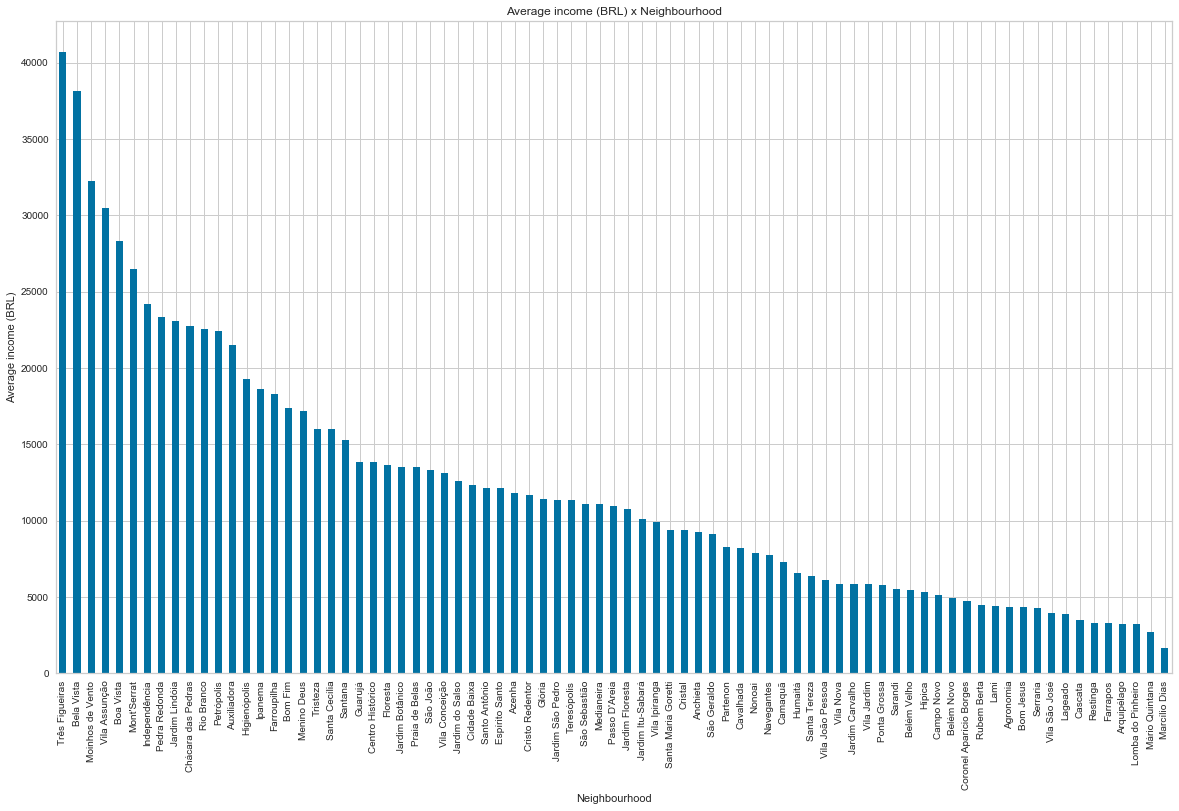

In [179]:
df_sorted=df.sort_values("Average income (BRL)",ascending=False, inplace=False)

ax = df_sorted["Average income (BRL)"].plot(kind='bar', figsize=(20, 12))

plt.xlabel('Neighbourhood') # add to x-label to the plot
plt.ylabel('Average income (BRL)') # add y-label to the plot
plt.title('Average income (BRL) x Neighbourhood') # add title to the plot
ax.set_xticklabels(df_sorted['Neighbourhood'])


plt.show()

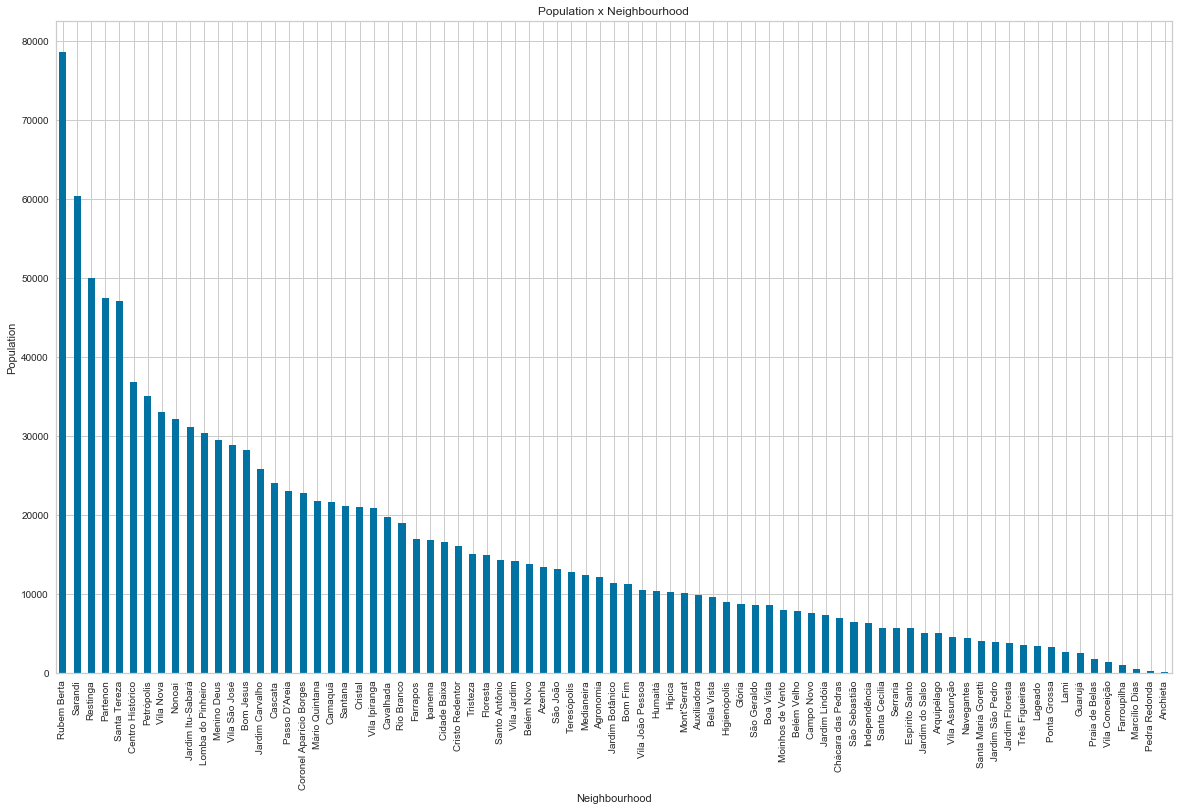

In [180]:
df_sorted=df.sort_values("Population",ascending=False, inplace=False)

ax = df_sorted["Population"].plot(kind='bar', figsize=(20, 12))

plt.xlabel('Neighbourhood') # add to x-label to the plot
plt.ylabel('Population') # add y-label to the plot
plt.title('Population x Neighbourhood') # add title to the plot
ax.set_xticklabels(df_sorted['Neighbourhood'])


plt.show()

.

To understand if there is any sort of relationship and to exclude some neighbourhoods based on the average income and on the population, a scatter is shown below:

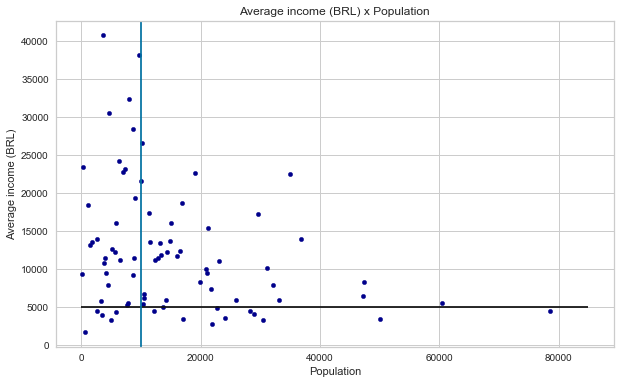

In [227]:
df_sorted.plot(kind='scatter', x= 'Population', y='Average income (BRL)', figsize=(10, 6), color='darkblue')

plt.title('Average income (BRL) x Population')
plt.xlabel('Population')
plt.ylabel('Average income (BRL)')
plt.axvline(x=10000, ymin=0, ymax=45000)
plt.hlines(5000, 0, 85000)

plt.show()

.

Create Dataframe excluding neighbourhoods with low average income (less than BRL 10000,00) and low population (less than 5000 people).

In [208]:
df_candidates = df[df['Population'] > 5000]
df_candidates = df_candidates[df_candidates['Average income (BRL)'] > 10000]
df_candidates = df_candidates.reset_index(drop=True)
df_candidates

,Neighbourhood,Population,Average income (BRL),Latitude,Longitude
0,Auxiliadora,9985,"21,527.00",-30.02,-51.19
1,Azenha,13449,"11,803.00",-30.05,-51.22
2,Bela Vista,9621,"38,148.00",-30.03,-51.19
3,Boa Vista,8691,"28,336.00",-30.02,-51.18
4,Bom Fim,11351,"17,380.00",-30.03,-51.21
5,Centro Histórico,36862,"13,871.00",-30.03,-51.23
6,Chácara das Pedras,7034,"22,748.00",-30.03,-51.16
7,Cidade Baixa,16634,"12,320.00",-30.04,-51.22
8,Cristo Redentor,16103,"11,671.00",-30.01,-51.16
9,Espírito Santo,5734,"12,122.00",-30.15,-51.22


.

K-Means is an unsupervised Machine Learning algorithm. The last analysis step in this project was use K-Means to organize the neighbourhoods into clusters based on the similarity between each neighbourhood. To determine the constant "k", the elbow method was used. To do so, the kelbow_visualizer function from yellowbrick library was used. Results are presented as follows:

C:\Users\bruno\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\bruno\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


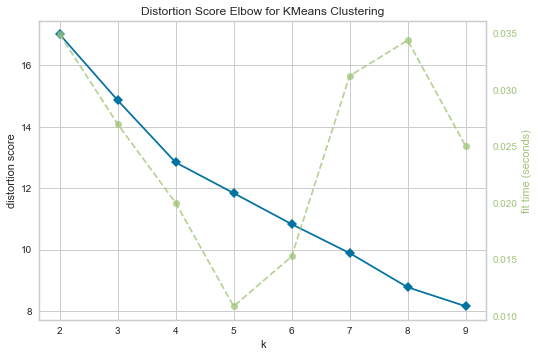

C:\Users\bruno\Anaconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000015E22E3E0F0>,
                 k=None, model=None)

In [209]:
# run k-means clustering
from yellowbrick.cluster.elbow import kelbow_visualizer
poa_grouped_clustering = poa_grouped.drop('Neighbourhood', 1)

kelbow_visualizer(KMeans(random_state=0), poa_grouped_clustering, k=(2,10))

.

The function itself could not identify which was the best "k". This might be a result of a few factors. It could be due to the quality of data acquired from Foursquare or because there is no significant difference between neighbourhoods, for example. To overcome this problem, a visual analysis was performed using the elbow chart. The most significant elbow in this chart was in k=4. Therefore, this was the input in K-Means.

In [210]:
# set number of clusters
kclusters = 4

poa_grouped_clustering = poa_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(poa_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 2, 0, 2, 0, 0, 0, 3, 0])

In [212]:
# add clustering labels
neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop("Cluster Labels", axis =1)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

poa_merged = df

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
poa_merged = poa_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

poa_merged["Cluster Labels"] = poa_merged["Cluster Labels"].fillna(4)
poa_merged["Cluster Labels"] = poa_merged["Cluster Labels"].astype(int)


poa_merged # check the last columns!

,Neighbourhood,Population,Average income (BRL),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agronomia,12222,"4,378.00",-30.09,-51.12,4,NaN,NaN,NaN,NaN,NaN
1,Anchieta,203,"9,251.00",-29.98,-51.17,4,NaN,NaN,NaN,NaN,NaN
2,Arquipélago,5061,"3,256.00",-29.99,-51.23,2,Restaurant,Wine Bar,Churrascaria,Food Truck,Food Stand
3,Auxiliadora,9985,"21,527.00",-30.02,-51.19,0,German Restaurant,Restaurant,Italian Restaurant,Chinese Restaurant,Southern Brazilian Restaurant
4,Azenha,13449,"11,803.00",-30.05,-51.22,2,Restaurant,Churrascaria,Bar,Sandwich Place,Latin American Restaurant
5,Bela Vista,9621,"38,148.00",-30.03,-51.19,0,Burger Joint,Pizza Place,Bistro,Brazilian Restaurant,Wine Bar
6,Belém Novo,13787,"4,939.00",-30.21,-51.17,2,Bistro,Restaurant,Wine Bar,Cocktail Bar,Food Truck
7,Belém Velho,7876,"5,434.00",-30.11,-51.18,0,Buffet,Wine Bar,Cocktail Bar,French Restaurant,Food Truck
8,Boa Vista,8691,"28,336.00",-30.02,-51.18,0,Restaurant,Chinese Restaurant,Burger Joint,Sushi Restaurant,Italian Restaurant
9,Bom Jesus,28229,"4,367.00",-30.04,-51.16,3,Pizza Place,Wine Bar,Cocktail Bar,Food Truck,Food Stand


After creating the clusters, some neighbourhoods were not assigned to any cluster because they did not have any venues in Foursquare. It is possible to infer that the Foursquare data is incomplete and its quality may compromise a real project if used. However, for the sake of this project, neighbourhoods with no venues were assigned to an extra cluster to allow a better analysis.

.

The following step was to create a map using Follium. Each color represents a different cluster.

In [213]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(poa_merged['Latitude'], poa_merged['Longitude'], poa_merged['Neighbourhood'], poa_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The each cluster was analyzed separetely based on its characteristics.

Cluster 1 data is shown below:

In [214]:
print(poa_merged[poa_merged["Cluster Labels"] == 0].count().head(1))
poa_merged.loc[poa_merged['Cluster Labels'] == 0].head(47)

Neighbourhood    47
dtype: int64


,Neighbourhood,Population,Average income (BRL),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,Auxiliadora,9985,"21,527.00",-30.02,-51.19,0,German Restaurant,Restaurant,Italian Restaurant,Chinese Restaurant,Southern Brazilian Restaurant
5,Bela Vista,9621,"38,148.00",-30.03,-51.19,0,Burger Joint,Pizza Place,Bistro,Brazilian Restaurant,Wine Bar
7,Belém Velho,7876,"5,434.00",-30.11,-51.18,0,Buffet,Wine Bar,Cocktail Bar,French Restaurant,Food Truck
8,Boa Vista,8691,"28,336.00",-30.02,-51.18,0,Restaurant,Chinese Restaurant,Burger Joint,Sushi Restaurant,Italian Restaurant
10,Bom Fim,11351,"17,380.00",-30.03,-51.21,0,Restaurant,Vegetarian / Vegan Restaurant,Buffet,Bistro,Pizza Place
11,Camaquã,21723,"7,315.00",-30.11,-51.24,0,Burger Joint,Pizza Place,Fast Food Restaurant,Fried Chicken Joint,Wine Bar
14,Cavalhada,19854,"8,228.00",-30.11,-51.23,0,Burger Joint,Pastelaria,Fast Food Restaurant,Bar,Sandwich Place
15,Centro Histórico,36862,"13,871.00",-30.03,-51.23,0,Brazilian Restaurant,Restaurant,Bar,Pizza Place,Buffet
16,Chácara das Pedras,7034,"22,748.00",-30.03,-51.16,0,Fast Food Restaurant,Burger Joint,Southern Brazilian Restaurant,Italian Restaurant,Sandwich Place
17,Cidade Baixa,16634,"12,320.00",-30.04,-51.22,0,Bar,Pub,Pizza Place,Dive Bar,Sushi Restaurant


.

Cluster 2 data is shown below:

In [215]:
print(poa_merged[poa_merged["Cluster Labels"] == 1].count().head(1))
poa_merged.loc[poa_merged['Cluster Labels'] == 1].head(9)

Neighbourhood    9
dtype: int64


,Neighbourhood,Population,Average income (BRL),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
18,Coronel Aparício Borges,22786,"4,763.00",-30.07,-51.18,1,Brazilian Restaurant,Burger Joint,Wine Bar,Comfort Food Restaurant,French Restaurant
20,Cristo Redentor,16103,"11,671.00",-30.01,-51.16,1,Brazilian Restaurant,Pizza Place,Bar,Wine Bar,Food Truck
48,Navegantes,4475,"7,777.00",-30.00,-51.20,1,Brazilian Restaurant,Southern Brazilian Restaurant,Food Court,Pub,Restaurant
52,Pedra Redonda,316,"23,353.00",-30.13,-51.24,1,Brazilian Restaurant,Sandwich Place,Burger Joint,Wine Bar,Cocktail Bar
61,Santa Tereza,47175,"6,358.00",-30.07,-51.22,1,Brazilian Restaurant,Wine Bar,Cocktail Bar,French Restaurant,Food Truck
66,Vila São José,28957,"3,960.00",-30.00,-51.20,1,Brazilian Restaurant,Southern Brazilian Restaurant,Pub,Restaurant,Churrascaria
68,Sarandi,60403,"5,511.00",-29.99,-51.11,1,BBQ Joint,Brazilian Restaurant,Wine Bar,Comfort Food Restaurant,French Restaurant
70,Teresópolis,12844,"11,341.00",-30.08,-51.21,1,Brazilian Restaurant,Food Truck,Wine Bar,Cocktail Bar,French Restaurant
74,Vila Conceição,1467,"13,156.00",-30.12,-51.26,1,Food Truck,Brazilian Restaurant,Wine Bar,Cocktail Bar,French Restaurant


.

Cluster 3 data is shown below:

In [216]:
print(poa_merged[poa_merged["Cluster Labels"] == 2].count().head(1))
poa_merged.loc[poa_merged['Cluster Labels'] == 2].head(5)

Neighbourhood    5
dtype: int64


,Neighbourhood,Population,Average income (BRL),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Arquipélago,5061,"3,256.00",-29.99,-51.23,2,Restaurant,Wine Bar,Churrascaria,Food Truck,Food Stand
4,Azenha,13449,"11,803.00",-30.05,-51.22,2,Restaurant,Churrascaria,Bar,Sandwich Place,Latin American Restaurant
6,Belém Novo,13787,"4,939.00",-30.21,-51.17,2,Bistro,Restaurant,Wine Bar,Cocktail Bar,Food Truck
21,Espírito Santo,5734,"12,122.00",-30.15,-51.22,2,Italian Restaurant,Restaurant,Wine Bar,Cocktail Bar,Food Truck
40,Lami,2699,"4,444.00",-30.23,-51.10,2,Restaurant,Wine Bar,Churrascaria,Food Truck,Food Stand


.

Cluster 4 data is shown below:

In [217]:
print(poa_merged[poa_merged["Cluster Labels"] == 3].count().head(1))
poa_merged.loc[poa_merged['Cluster Labels'] == 3].head(4)

Neighbourhood    4
dtype: int64


,Neighbourhood,Population,Average income (BRL),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
9,Bom Jesus,28229,"4,367.00",-30.04,-51.16,3,Pizza Place,Wine Bar,Cocktail Bar,Food Truck,Food Stand
33,Jardim Carvalho,25915,"5,841.00",-30.05,-51.14,3,Pizza Place,Churrascaria,Cocktail Bar,Food Truck,Food Stand
44,Medianeira,12428,"11,110.00",-30.07,-51.21,3,Pizza Place,Wine Bar,Cocktail Bar,Food Truck,Food Stand
76,Vila Jardim,14251,"5,830.00",-30.03,-51.15,3,Pizza Place,Wine Bar,Cocktail Bar,Food Truck,Food Stand


.

Cluster 5 (NaN values) data is shown below:

In [218]:
print(poa_merged[poa_merged["Cluster Labels"] == 4].count().head(1))
poa_merged.loc[poa_merged['Cluster Labels'] == 4].head()

Neighbourhood    14
dtype: int64


,Neighbourhood,Population,Average income (BRL),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agronomia,12222,"4,378.00",-30.09,-51.12,4,NaN,NaN,NaN,NaN,NaN
1,Anchieta,203,"9,251.00",-29.98,-51.17,4,NaN,NaN,NaN,NaN,NaN
12,Campo Novo,7652,"5,170.00",-30.13,-51.20,4,NaN,NaN,NaN,NaN,NaN
13,Cascata,24130,"3,487.00",-30.09,-51.17,4,NaN,NaN,NaN,NaN,NaN
19,Cristal,21054,"9,383.00",-30.08,-51.24,4,NaN,NaN,NaN,NaN,NaN


.

Neighbourhoods with no data of its venues were excluded from the analysis. Additionally, in a qualitative analysis, Cluster 4 is known for pubs and bars and will be also excluded.

In [219]:
df_exclude = poa_merged[poa_merged["Cluster Labels"] == 4]
df_candidates = df_candidates[~df_candidates["Neighbourhood"].isin(df_exclude['Neighbourhood'])].dropna()

df_exclude = poa_merged[poa_merged["Cluster Labels"] == 3]
df_candidates = df_candidates[~df_candidates["Neighbourhood"].isin(df_exclude['Neighbourhood'])].dropna()

print("df_candidates shape =", df_candidates.shape)
df_candidates.head()

df_candidates shape = (31, 5)


,Neighbourhood,Population,Average income (BRL),Latitude,Longitude
0,Auxiliadora,9985,"21,527.00",-30.02,-51.19
1,Azenha,13449,"11,803.00",-30.05,-51.22
2,Bela Vista,9621,"38,148.00",-30.03,-51.19
3,Boa Vista,8691,"28,336.00",-30.02,-51.18
4,Bom Fim,11351,"17,380.00",-30.03,-51.21


.

Lastly, venues from the candidate neighbourhoods will be individually analyzed to determine which neighbourhoods have less Italian Restaurants. The objective is to establish the new restaurant in a Neighbourhood with no Italian Restaurants.



In [220]:
poa_italian = pd.DataFrame(poa_restaurants[poa_restaurants['Venue Category']=='Italian Restaurant'])
poa_italian.head(3)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
9,Auxiliadora,-30.02,-51.19,Casa Vecchia,-30.02,-51.19,Italian Restaurant
19,Auxiliadora,-30.02,-51.19,Sette Pastabar,-30.02,-51.19,Italian Restaurant
40,Boa Vista,-30.02,-51.18,Casa Italia,-30.03,-51.19,Italian Restaurant


In [221]:
poa_italian = poa_italian.drop(columns=['Neighbourhood Latitude', 'Neighbourhood Longitude','Venue','Venue Latitude', 'Venue Longitude'])
poa_italian = poa_italian.groupby("Neighbourhood").count()
poa_italian

,Venue Category
Neighbourhood,
Auxiliadora,2
Boa Vista,1
Bom Fim,2
Centro Histórico,1
Chácara das Pedras,2
Cidade Baixa,2
Espírito Santo,1
Humaitá,1
Independência,1


In [222]:
df_exclude = poa_italian
df_exclude= df_exclude.reset_index()

In [223]:
df_candidates = df_candidates[~df_candidates["Neighbourhood"].isin(df_exclude['Neighbourhood'])].dropna()

After excluding the neighbourhoods that have at least one Italian restaurant, the final list of candidates is shown below:

In [224]:
df_candidates.reset_index(drop=True, inplace=True)
df_candidates

,Neighbourhood,Population,Average income (BRL),Latitude,Longitude
0,Azenha,13449,"11,803.00",-30.05,-51.22
1,Bela Vista,9621,"38,148.00",-30.03,-51.19
2,Cristo Redentor,16103,"11,671.00",-30.01,-51.16
3,Floresta,14941,"13,629.00",-30.02,-51.21
4,Glória,8809,"11,407.00",-30.07,-51.20
5,Higienópolis,9096,"19,283.00",-30.02,-51.18
6,Ipanema,16877,"18,634.00",-30.13,-51.23
7,Jardim do Salso,5143,"12,584.00",-30.05,-51.17
8,Menino Deus,29577,"17,160.00",-30.06,-51.22
9,Mont'Serrat,10236,"26,477.00",-30.03,-51.19


## SECTION 5: RESULTS AND DISCUSSION

The analysis showed that restaurants are pulverized in all Porto Alegre. In other words, there is no specific area in which restaurants are extremely concentrated. Moreover, there are some areas in which Foursquare did not provide any data on their restaurants. In this project, there were no constraints in terms of neighbourhoods in Porto Alegre. Therefore, the entire city was considered.


After collecting all data required for this project, the first criteria to narrow down the possible neighbourhoods for establishing a new restaurant were the population and the average income in each neighbourhood. This process excluded many location, reducing the candidate neighbourhoods to 42.


K-Means clustering provided some more information to exclude more neighbourhoods based on the characteristic of the restaurants in those clusters. However, this process was limited because of the lack of data. It allowed only two clusters to be excluded. The first excluded cluster was characterized by the pubs and bars. These neighbourhoods were excluded because the areas of interest must be characterized by restaurants specifically. The other cluster excluded from the analysis was characterized by not having any data on its restaurants.


At this point, the candidate areas were characterized by medium to high income and population, and the presence of restaurants. However, the objective was to find an area with restaurants, but with no Italian restaurant. Therefore, the last step was to exclude all other neighbourhoods that already have an Italian restaurant. The result of this process was a list of 24 neighbourhoods with no Italian restaurant and with people who have financial conditions to be a customer.

## SECTION 6: CONCLUSIONS

The main objective of this project was to determine the location of a new Italian restaurant in the city of Porto Alegre, Brazil. By using Foursquare data to determine the distribution of restaurants in the city and using socio-economical data from the neighbourhoods, it was possible to reduce the area where the restaurant could be established. The process is replicable to other cities depending on the available data. Other sources of evaluation of venues can be used to improve the results of the process. Lastly, to determine the final location for the restaurant, other factors would have to be taken into consideration including other characteristics of the neighbourhoods and the strategy to be implemented for this new restaurant.